# prep

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
import os
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# load 1 recording

In [63]:
mouse = 1380
date = 230207
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'
dir_data += f'V1_i{mouse}_{date}_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)

ncell: 135, nstim: 1, ntrial: 1257, nframe: 257


trace_cell_avg: (257,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (257,)


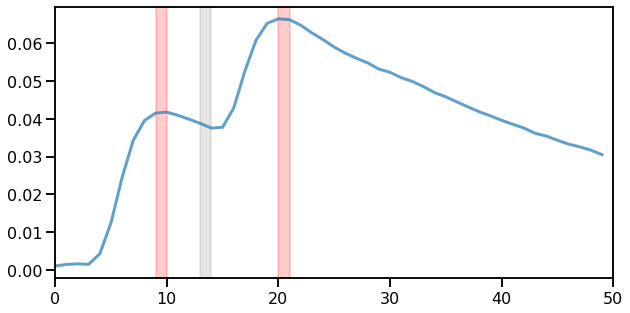

In [64]:
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(9,10, alpha=0.2, color='red')
ax.axvspan(13,14, alpha=0.2, color='gray')
ax.axvspan(20,21, alpha=0.2, color='red')
plt.xlim(0, 50);

In [65]:
# get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

resp_ad.shape, resp_tg.shape

((135, 1257), (135, 1257))

# make 1 tidy data

In [8]:
R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
R2_dfof = resp_tg.flatten()
dfof = np.hstack((R1_dfof, R2_dfof))

ncell = resp_ad.shape[0]
ntrial = resp_ad.shape[1]
cell_id = np.repeat(np.arange(ncell), ntrial)
cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

trial_id = np.tile(np.arange(ntrial), ncell)
trial_id = np.hstack((trial_id, trial_id))

stim_id_col = np.tile(stim_id[0], ncell)
stim_id_col = np.hstack((stim_id_col, stim_id_col))
stim_id_col = stim_id_col - 1 # stim id adjusted to 0-based index

len_df = ncell * ntrial * 2 # 2 for (R1, R2)
resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

# construct dataframe
df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'stim_id': stim_id_col, 'resp_id': resp_id})
df_tidy.tail(5)
# TODO: when we need to concat across experiments, can add col for mouse, date, area, session

,dfof,cell_id,trial_id,stim_id,resp_id
339385,-0.027403,134,1252,0,R2
339386,0.017285,134,1253,0,R2
339387,-0.122659,134,1254,0,R2
339388,-0.165782,134,1255,0,R2
339389,0.073869,134,1256,0,R2


## trial filter

In [9]:
trial_filter_file = [f for f in os.listdir(dir_data) if f.__contains__('filter_trials_')]

trial_ok = np.array([])
for file in trial_filter_file:
    trial_filter = sio.loadmat(os.path.join(dir_data, file))
    trial_eye_ok = trial_filter['trial_eye_ok']
    trial_eye_ok = np.array([i[0] for i in trial_eye_ok], dtype=bool)
    trial_speed_ok = trial_filter['trial_speed_ok']
    trial_speed_ok = np.array([i[0] for i in trial_speed_ok], dtype=bool)
    trial_ok_sess = trial_eye_ok & trial_speed_ok
    trial_ok_sess = trial_ok_sess[:-1] # remove the last trial, which is not a full trial
    trial_ok = np.append(trial_ok, trial_ok_sess)

trial_ok = np.array(trial_ok, dtype=bool)
assert len(trial_ok) == trace_by_trial.shape[1]
# sum(trial_ok), len(trial_ok)

filter_trial = np.tile(trial_ok, ncell)
filter_trial = np.hstack((filter_trial, filter_trial))
df_tidy['filter_trial'] = filter_trial

In [10]:
print(f'trials that passed the filter: {sum(trial_ok)} / {len(trial_ok)}, \
    discarded: {(len(trial_ok) - sum(trial_ok)) / len(trial_ok)*100:.2f}%')

trials that passed the filter: 1055 / 1257,     discarded: 16.07%


## cell x stim filter
using vis_driven.ipynb  
TODO: refactor it into adp.py

In [11]:
df_tidy['filter_cell'] = np.nan
df_tidy['filter_cell_stim'] = np.nan

with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
    filter_file = pickle.load(f)
filter_cell_stim = filter_file['img_driven']
filter_cell = filter_file['vis_driven']

# fill filter_cell_stim into df_tidy: for icell and istim
for icell in np.arange(filter_cell_stim.shape[0]):
    df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
    for istim in np.arange(filter_cell_stim.shape[1]):
        df_tidy.loc[(df_tidy['stim_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
df_tidy

# df_tidy['filter_cell_stim'] = True
# print('not using filter_cell_stim')

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim
0,0.153075,0,0,0,R1,False,False,False
1,0.052223,0,1,0,R1,True,False,False
2,0.092578,0,2,0,R1,True,False,False
3,0.060746,0,3,0,R1,True,False,False
4,0.175948,0,4,0,R1,True,False,False
...,...,...,...,...,...,...,...,...
339385,-0.027403,134,1252,0,R2,True,False,False
339386,0.017285,134,1253,0,R2,False,False,False
339387,-0.122659,134,1254,0,R2,False,False,False
339388,-0.165782,134,1255,0,R2,False,False,False


## save tidy data

In [30]:
# save to csv
df_tidy.to_csv(os.path.join(dir_data, 'df_tidy.csv'), index=False)

# ls dir_data
os.listdir(dir_data)

['dfof align zoomin.jpg',
 'dfof align.jpg',
 'dfof.mat',
 'dfof_trial.mat',
 'df_tidy.csv',
 'filter_trials_by_pupil_or_speed_002.mat',
 'filter_trials_by_pupil_or_speed_003.mat',
 'filter_trials_by_pupil_or_speed_004.mat',
 'find_ca_latency_ca_window.jpg',
 'resp_base_trialwise.mat',
 'trace_aligned.mat',
 'trace_trial_stim.mat',
 'vis_driven.pickle']

# load multi tidy data

In [101]:
# read xls
dir_meta = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
data_meta = pd.read_excel(os.path.join(dir_meta, 'adp_dataset_master.xlsx'))

data_meta = data_meta[data_meta.paradigm == 'grat_SF6']
data_meta = data_meta[data_meta.note != 'bad']

data_meta.tail(15)

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
95,1375,230103,V1,150,2.0,NaN,NaN,grat_SF6,6s,NaN,NaN
96,1375,230103,V1,150,3.0,NaN,NaN,grat_SF6,6s,NaN,NaN
98,1380,230127,V1,150,3.0,NaN,NaN,grat_SF6,6s,NaN,NaN
99,1380,230127,V1,150,4.0,NaN,NaN,grat_SF6,6s,NaN,NaN
100,1380,230127,V1,150,5.0,NaN,NaN,grat_SF6,6s,NaN,NaN
104,1375,230209,V1,200,2.0,NaN,NaN,grat_SF6,6s,NaN,NaN
105,1375,230209,V1,200,3.0,NaN,NaN,grat_SF6,6s,NaN,NaN
106,1375,230209,V1,200,4.0,NaN,NaN,grat_SF6,6s,NaN,NaN


In [149]:
date_unique = data_meta.date.unique()

df_tidy = pd.DataFrame()

for idate in date_unique[:-1]: # exclude the last date, which is incomplete
    data_meta_sess = data_meta[data_meta.date == idate]
    print(f'{idate}: {len(data_meta_sess)} sessions')

    mouse = data_meta[data_meta.date == idate].mouse.unique()[0]
    print(f'mouse: {mouse}')

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'
    dir_data += f'V1_i{mouse}_{idate}_cellpose'
    print(f'dir_data: {dir_data}')

    df_tidy_date = pd.read_csv(os.path.join(dir_data, 'df_tidy.csv'))
    df_tidy_date['mouse'] = mouse
    df_tidy_date['date'] = idate
    df_tidy_date['cell_id'] = df_tidy_date.date * 1000 + df_tidy_date.cell_id # cell_id adjusted to be unique across mice and dates
    df_tidy = pd.concat([df_tidy, df_tidy_date], axis=0).reset_index(drop=True)

df_tidy.sample(10)

230103: 2 sessions
mouse: 1375
dir_data: \\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/V1_i1375_230103_cellpose
230127: 3 sessions
mouse: 1380
dir_data: \\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/V1_i1380_230127_cellpose


,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim,mouse,date
450631,0.014737,230127059,605,0,R2,True,True,True,1380,230127
425046,0.091032,230127043,1276,2,R2,True,True,False,1380,230127
308989,0.050294,230127076,89,1,R1,True,True,True,1380,230127
213954,-0.011048,230127018,232,3,R1,True,True,False,1380,230127
123710,0.084582,230103031,246,3,R2,True,True,False,1375,230103
314275,0.016980,230127079,452,1,R1,True,True,False,1380,230127
272348,0.209920,230127053,1191,4,R1,True,True,False,1380,230127
22697,0.112003,230103022,433,2,R1,True,True,True,1375,230103
102384,-0.006604,230103010,172,2,R2,True,True,False,1375,230103
384970,-0.012207,230127019,584,5,R2,True,True,False,1380,230127


# tidy data filtered 
discarded invalid trial and cell x stim combo

In [150]:
df_filter = df_tidy[df_tidy['date'] # always true
                    # & df_tidy['filter_trial'] 
                    # & df_tidy['filter_cell_stim'] # img driven filter
                    & df_tidy['filter_cell'] # vis driven filter
                    ]

# df_filter = df_tidy.copy()
# print('trial filtering off')

df_filter#.sample(5, random_state=42)
# df_filter.stim_id.value_counts() // df_filter.cell_id.nunique() // 2 # 2 is for R1 and R2. each stim repeat 130+ times

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim,mouse,date
0,-0.133319,230103000,0,4,R1,True,True,False,1375,230103
1,0.113303,230103000,1,2,R1,True,True,True,1375,230103
2,-0.018100,230103000,2,2,R1,True,True,True,1375,230103
3,-0.032178,230103000,3,3,R1,True,True,True,1375,230103
4,-0.065120,230103000,4,2,R1,True,True,True,1375,230103
...,...,...,...,...,...,...,...,...,...,...
522225,-0.044726,230127102,1636,4,R2,True,True,False,1380,230127
522226,0.002843,230127102,1637,0,R2,True,True,True,1380,230127
522227,-0.027912,230127102,1638,1,R2,False,True,True,1380,230127
522228,0.070413,230127102,1639,5,R2,True,True,False,1380,230127


# adaptation vs SF
## construct filter_pref

In [152]:
df_pref = df_filter.copy()
df_pref['filter_pref'] = False

# for each cell, find the stim with the largest resp
for icell in df_filter.cell_id.unique():
    df_cell = df_pref[df_pref['cell_id']==icell]
    df_cell = df_cell[df_cell['resp_id']=='R1'] # only use R1
    if len(df_cell) == 0:
        continue
    df_cell = df_cell.sort_values(by='dfof', ascending=False) # sort by dfof, largest first
    pref_stim = df_cell.iloc[0]['stim_id'] # stim id of the largest resp
    df_pref.loc[(df_pref['cell_id']==icell) & (df_pref['stim_id']==pref_stim), 'filter_pref'] = True

df_pref = df_pref[df_pref['filter_pref']] # only retain preferred stim x cell combo
df_pref

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell,filter_cell_stim,mouse,date,filter_pref
3,-0.032178,230103000,3,3,R1,True,True,True,1375,230103,True
5,-0.008223,230103000,5,3,R1,False,True,True,1375,230103,True
7,-0.014856,230103000,7,3,R1,False,True,True,1375,230103,True
9,0.055654,230103000,9,3,R1,True,True,True,1375,230103,True
23,0.021640,230103000,23,3,R1,False,True,True,1375,230103,True
...,...,...,...,...,...,...,...,...,...,...,...
522205,0.015390,230127102,1616,0,R2,True,True,True,1380,230127,True
522214,-0.007197,230127102,1625,0,R2,True,True,True,1380,230127,True
522215,0.002483,230127102,1626,0,R2,False,True,True,1380,230127,True
522221,-0.074150,230127102,1632,0,R2,True,True,True,1380,230127,True


## boot adp for pop

In [153]:
df_pref.stim_id.value_counts().sort_index() // df_pref.cell_id.nunique() // 2 # stim nrep x ncell x 2 (R1, R2)

0    81
1    35
2    43
3    36
4    22
5     9
Name: stim_id, dtype: int64

In [154]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 200 # 18 sec for 500 iter
nrep_selected = 30

adp_boot = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                    .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
    R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                    .reset_index()['dfof'].values)
    adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7)
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    adp_boot.append(adp_agg)
print('adp hard thresholding')

adp_boot = np.array(adp_boot)
adp_boot_agg = np.mean(adp_boot, axis=0) # sum over all bootstraps

100%|██████████| 200/200 [00:15<00:00, 13.31it/s]

adp hard thresholding


In [155]:
# preferred stim x cell combo

df_adp_pref = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum()) # dfof col was not used
                .reset_index())

df_adp_pref['adp_pref'] = adp_boot_agg
df_adp_pref = df_adp_pref.dropna(subset=['adp_pref']) # remove nan, which is adp outliers
df_adp_pref.tail(), df_adp_pref.shape, df_adp_pref.stim_id.max()

(     stim_id    cell_id      dfof  adp_pref
 176        4  230127060  0.959997  0.174566
 177        4  230127062  2.228465 -0.017899
 178        4  230127074  1.790105  0.037032
 179        4  230127093  3.212933 -0.075815
 180        4  230127094  0.608026 -0.508919,
 (155, 4),
 4)

### boxplot across cells
for each SF, take cells that prefer this grating SF. boxplot errorbar is across cells

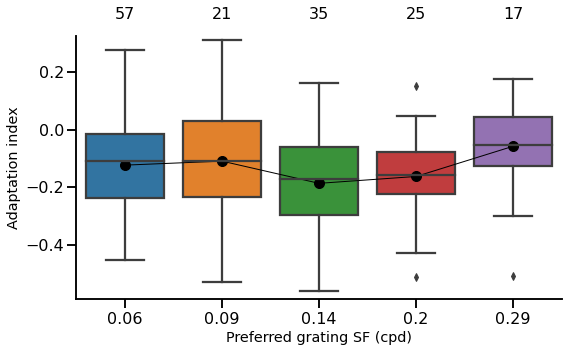

In [156]:
# for each stim_id, plot adp_pref for each cell in a boxplot

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax)
ax.plot(df_adp_pref.groupby('stim_id')['adp_pref'].mean().values, 'k', marker='o', markersize=10, linewidth=1)

# add text at each xtick
ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values # ncell for each stim_id
for i, ncell_iSF in enumerate(ncell_SF):
    ncell_iSF = int(ncell_iSF)
    ax.text(i, 0.4, ncell_iSF, ha='center', va='center', fontsize=16)

ax.set_xlabel('Preferred grating SF (cpd)')
cpd_array = np.round(np.geomspace(0.03, 0.9, num=10), 2)[2:-2] # remove low freq and high freq
try:
    ax.set_xticklabels(cpd_array)
except:
    ax.set_xticklabels(cpd_array[:-1])
    assert df_adp_pref.stim_id.max() == 4 # there is no stim_id 5 (highest SF) left after adp thres
ax.set_ylabel('Adaptation index')
ax.set_ylim([np.nanmin(df_adp_pref['adp_pref'].values * 1.05), np.nanmax(df_adp_pref['adp_pref'].values * 1.05)])
# ax.set_title('Adaptation to preferred grating SF');

# turn off upper and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
fig_dir = r'C:\Users\ll357\Documents\inter\results\adp vs SF/'.replace('\\', '/')
# fig.savefig(os.path.join(fig_dir, 'adp_pref_grat_6SF_trial_filter.pdf'), dpi=300)

### one way anova

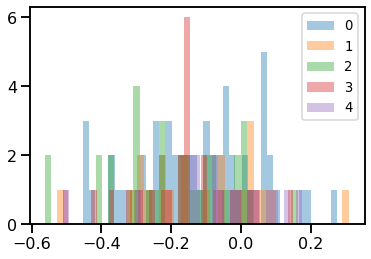

In [157]:
# test assumption of normality: looks maybe normal, need Shapiro-Wilk test

df_adp_pref_dropna = df_adp_pref.dropna(subset=['adp_pref'])
gb = df_adp_pref_dropna.groupby('stim_id')
adp_SF = []
for stim_id, group in gb:
    # print(stim_id)
    # print(group)
    # print(group['adp_pref'].values[:5])
    adp_iSF = group['adp_pref'].values
    adp_SF.append(adp_iSF)
    plt.hist(adp_iSF, bins=40, alpha=0.4, label=stim_id)
plt.legend();

In [158]:
# test assumption of equal variance: looks not equal, need Levene test, bartlett test, or fligner-killeen test
# "ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power" - https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance
adp_SF_var = [np.var(adp_iSF) for adp_iSF in adp_SF]
adp_SF_var

# test assumption of independence: no idea

[0.028224436147230844,
 0.03342460837046209,
 0.027669656320709075,
 0.02136158112260261,
 0.026137608417358158]

In [159]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_adp_pref_dropna = df_adp_pref.dropna()

# perform one-way ANOVA
import scipy.stats as stats
stats.f_oneway(df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==0]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==1]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==2]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==3]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==4]['adp_pref'].values,
                # df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==5]['adp_pref'].values, # last stim_id has only 1 cell
                )

F_onewayResult(statistic=2.0725551465754886, pvalue=0.08718870537016186)

### boxplot across boots
for each SF, take cells that prefer this grating SF. boxplot errorbar is across boots (already averaged across cells)

In [160]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 200
nrep_selected = 30

adp_boot_pop = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                .to_frame().reset_index()
                .groupby(['stim_id'])['dfof'] # sum over cells preferring each stim
                .sum().values
                )
    R2_agg = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                .to_frame().reset_index()
                .groupby(['stim_id'])['dfof']
                .sum().values
                )
    adp_agg = (R2_agg - R1_agg) / (R1_agg + 1e-7)
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    adp_boot_pop.append(adp_agg)
print('adp hard thresholding')

adp_boot_pop = np.array(adp_boot_pop)
adp_boot_pop.shape # nboot x nstim

100%|██████████| 200/200 [00:15<00:00, 13.23it/s]

adp hard thresholding


(200, 6)

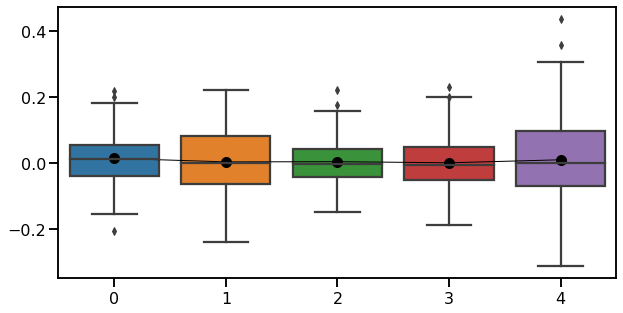

In [161]:
# df_adp_pref_pop = pd.DataFrame(adp_boot_pop, columns=df_adp_pref.stim_id.unique()) # only works if all stim_id survived adp thres
df_adp_pref_pop = pd.DataFrame(adp_boot_pop, columns=np.arange(0, 6)) # only works if all stim_id survived adp thres
df_adp_pref_pop = df_adp_pref_pop.drop(columns=5) # drop column 5 due to ncell=1
# df_adp_pref_pop

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_adp_pref_pop, ax=ax)
ax.plot(df_adp_pref_pop.mean().values, 'k', marker='o', markersize=10, linewidth=1)

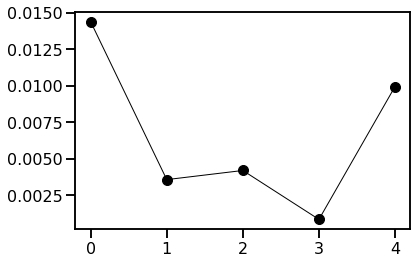

In [164]:
plt.plot(df_adp_pref_pop.mean().values, 'k', marker='o', markersize=10, linewidth=1)

# trial filter impact on adp stability
## using new grat1
copied from grat1_mix50.ipynb  
TODO: refactor

((135, 1257, 257), (1, 1257), (135, 1257), (135, 1257), (1257,))

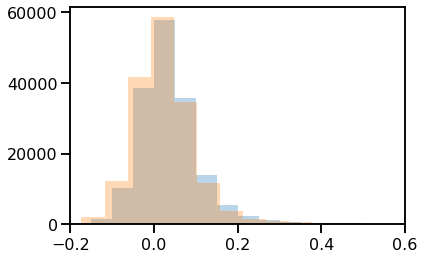

In [66]:
plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

trace_by_trial.shape, stim_id.shape, resp_ad.shape, resp_tg.shape, trial_ok.shape

## no trial filter

### pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [67]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((1257,), -0.31622181868903454, -0.1452518361800512)

In [68]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 10): # >= 10 groups of trials
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

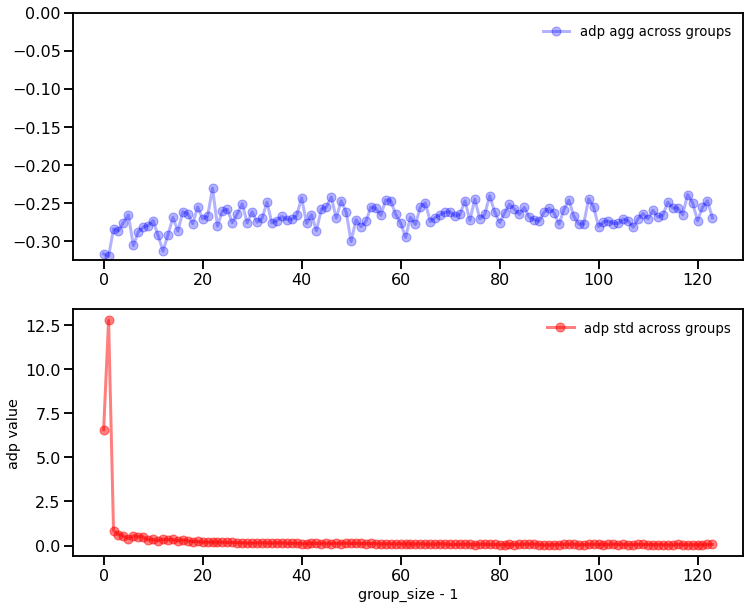

In [69]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
# plt.axhline(-0.32, color='g')
# plt.xticks(np.arange(0,110,10))
plt.ylim(plt.ylim()[0], 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.xscale('log')
# plt.ylim(0, 0.5)
plt.ylabel('adp value')
plt.legend(frameon=False);

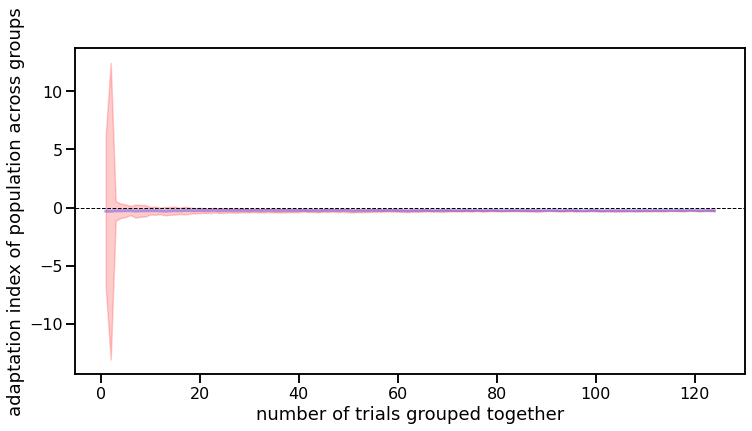

In [70]:
errbar = adp_std # adp_sem 
x = np.arange(1, adp_agg.shape[0]+1)

fig = plt.figure(figsize=(12, 6))
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

# plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index of population across groups', fontsize=18); #  across groups of different sizes

### single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [71]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

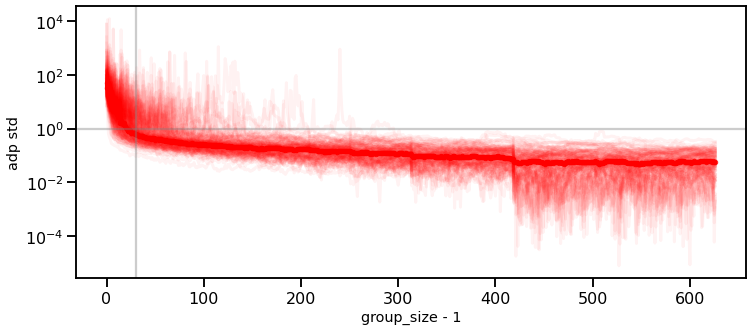

In [72]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, '.-', color='r', linewidth=1, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.axvline(30, alpha=0.4, color='gray')
# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
# plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('adp std');

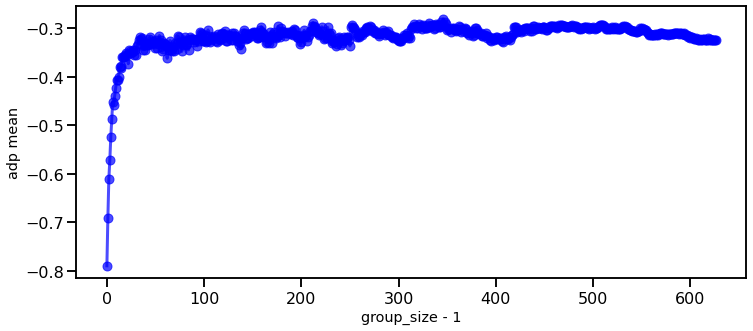

In [73]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

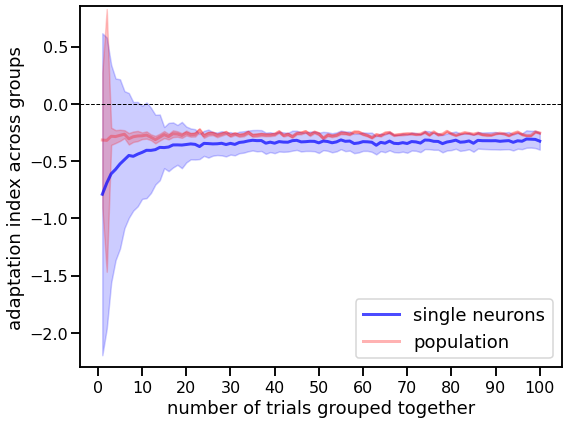

<Figure size 432x288 with 0 Axes>

In [74]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 100

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylim(-2.3, 0.85)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_group_trials_grat_6SF.pdf'), format='pdf')

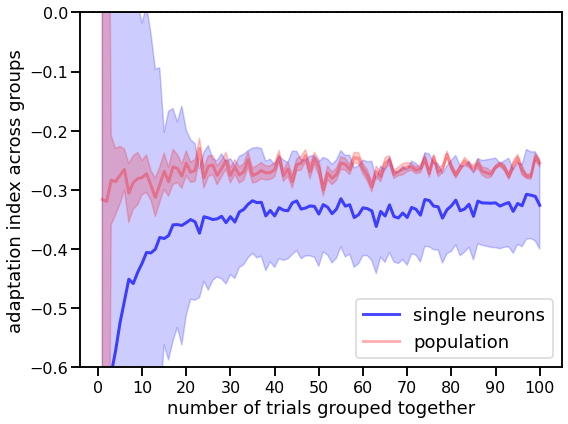

<Figure size 432x288 with 0 Axes>

In [78]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 100

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylim(-0.6, 0)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_group_trials_grat_6SF.pdf'), format='pdf')

## with trial filter

In [79]:
trace_by_trial = trace_by_trial[:, trial_ok, :]
stim_id = stim_id[0][trial_ok]
resp_ad = resp_ad[:, trial_ok]
resp_tg = resp_tg[:, trial_ok]

trace_by_trial.shape, stim_id.shape, resp_ad.shape, resp_tg.shape, trial_ok.shape, sum(trial_ok)

((135, 1055, 257), (1055,), (135, 1055), (135, 1055), (1257,), 1055)

### pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [80]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((1055,), -0.3501254920351018, -0.16113882489419268)

In [81]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 10): # >= 10 groups of trials
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

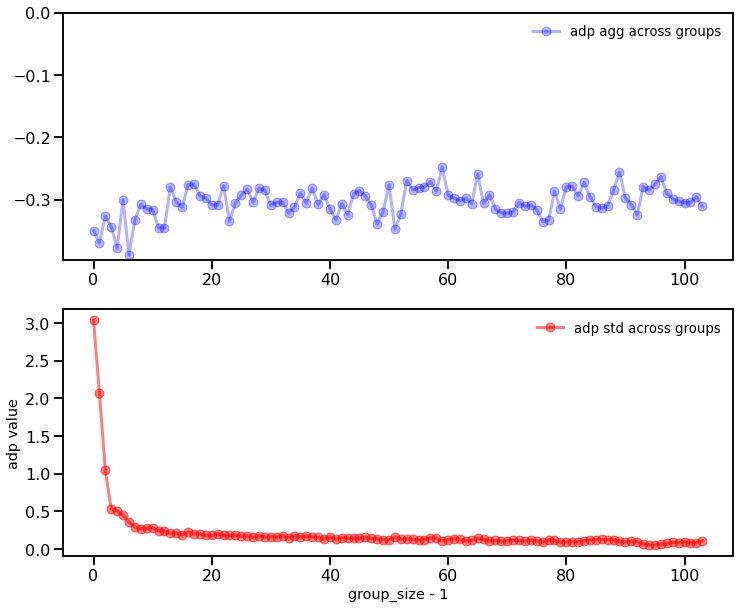

In [82]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
# plt.axhline(-0.32, color='g')
# plt.xticks(np.arange(0,110,10))
plt.ylim(plt.ylim()[0], 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.xscale('log')
# plt.ylim(0, 0.5)
plt.ylabel('adp value')
plt.legend(frameon=False);

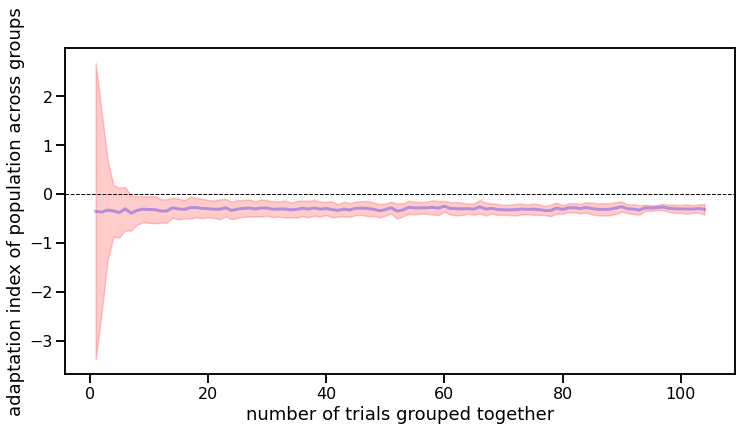

In [83]:
errbar = adp_std # adp_sem 
x = np.arange(1, adp_agg.shape[0]+1)

fig = plt.figure(figsize=(12, 6))
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

# plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index of population across groups', fontsize=18); #  across groups of different sizes

### single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [84]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

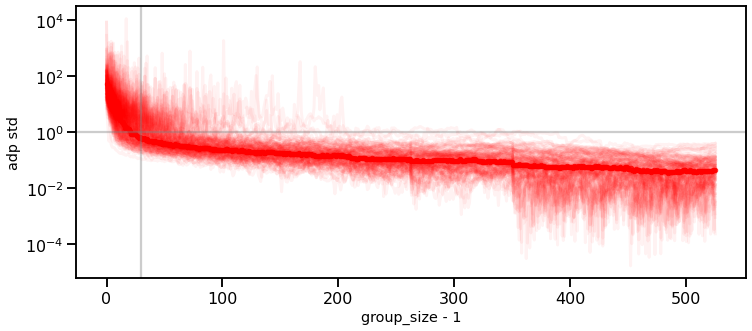

In [85]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, '.-', color='r', linewidth=1, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.axvline(30, alpha=0.4, color='gray')
# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
# plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('adp std');

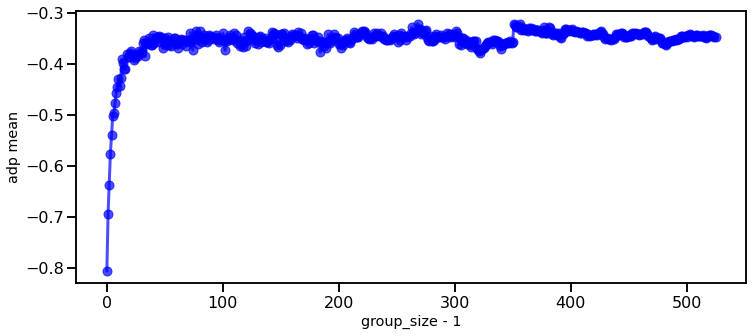

In [86]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

# plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

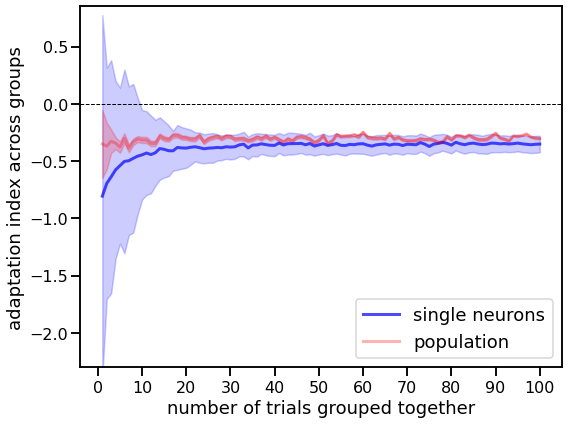

<Figure size 432x288 with 0 Axes>

In [87]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 100

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylim(-2.3, 0.85)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_group_trials_grat_6SF.pdf'), format='pdf')

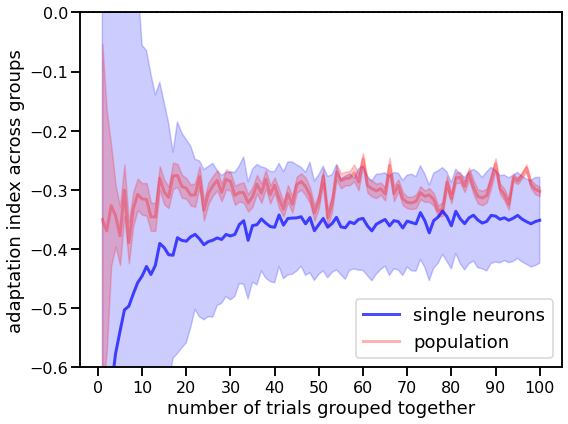

<Figure size 432x288 with 0 Axes>

In [88]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 100

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylim(-0.6, 0)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_group_trials_grat_6SF.pdf'), format='pdf')

In [91]:
print('for grat1 data, trial filtering cannot increase adp stability for single cell or population?')

for grat1 data, trial filtering cannot increase adp stability for single cell or population?
